# Evaluating and Improving Agent Workflows

Agent evaluation goes beyond simple accuracy. In this notebook:
1. **Rubric-based output evaluation** — LLM-as-judge with structured scoring
2. **Trajectory evaluation** — scoring the tool call sequence, not just the answer
3. **Self-correcting agents** — evaluation as a graph node that loops back on failure
4. **Batch evaluation** — running a test set and computing aggregate scores

In [1]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)
# Expects: OPENROUTER_API_KEY, SERPAPI_API_KEY
# Optional: LANGSMITH_API_KEY

True

## 1. Rubric-based output evaluation (LLM-as-judge)

We define a structured rubric with three dimensions and use an LLM to score each one. This gives us quantitative, reproducible evaluation — not just "looks good."

In [2]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI


class EvaluationResult(BaseModel):
    """Structured evaluation of an agent's response."""
    reasoning: str = Field(
        description="Repeat back key points of the answer given and explain in detail where your scores are coming from."
    )
    faithfulness: int = Field(
        # ge=1, le=5, Anthropic doesn't support this but OpenAI does
        description="Is the answer grounded in the provided context? 5 = every claim supported, 1 = mostly hallucinated. Answer must be 1, 2, 3, 4, or 5."
    )
    completeness: int = Field(
        # ge=1, le=5, Anthropic doesn't support this but OpenAI does
        description="Does the answer fully address the user's question? 5 = comprehensive, 1 = misses the point. Answer must be 1, 2, 3, 4, or 5."
    )
    conciseness: int = Field(
        # ge=1, le=5, Anthropic doesn't support this but OpenAI does
        description="Is the answer appropriately scoped? 5 = no fluff, 1 = excessive irrelevant detail. Answer must be 1, 2, 3, 4, or 5."
    )


EVAL_PROMPT = """You are evaluating an AI agent's response. Score each dimension 1-5.

**Faithfulness** (1-5): Is the answer grounded in the provided context? 5 = every claim is supported, 1 = mostly hallucinated.
**Completeness** (1-5): Does the answer fully address the user's question? 5 = comprehensive, 1 = misses the point.
**Conciseness** (1-5): Is the answer appropriately scoped? 5 = no fluff, 1 = excessive irrelevant detail.

Examples of a 1 in Faithfulness would include lying about the source of the information or making up details that are not in the context. A 2 in Faithfulness would include some minor inaccuracies or oversimplifications. A 3 in Faithfulness would include significant inaccuracies or omissions. A 4 in Faithfulness would include major inaccuracies or omissions. A 5 in Faithfulness would include every claim being supported by the context.

Examples of a 1 in Completeness would include answering only part of the question or not providing any relevant information. A 2 in Completeness would include providing some relevant information but missing important details. A 3 in Completeness would include providing a mostly complete answer but with some minor omissions. A 4 in Completeness would include providing a mostly complete answer but with some significant omissions. A 5 in Completeness would include providing a comprehensive answer that addresses all parts of the question.

Examples of a 1 in Conciseness would include providing an answer that is too long and verbose. A 2 in Conciseness would include providing an answer that is somewhat verbose. A 3 in Conciseness would include providing an answer that is moderately verbose. A 4 in Conciseness would include providing an answer that is somewhat concise. A 5 in Conciseness would include providing an answer that is very concise and to the point.

Context: {context}

Question: {question}

Answer: {answer}

Evaluate the answer."""

eval_llm = ChatOpenAI(
    model="openai/gpt-4.1-mini",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    temperature=0,
).with_structured_output(EvaluationResult)

/Users/sinanozdemir/Teaching/Pearson/oreilly-langgraph/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def evaluate_response(question: str, context: str, answer: str, model_name: str="openai/gpt-4.1-mini") -> EvaluationResult:
    """Evaluate a response using the rubric."""
    eval_llm = ChatOpenAI(
        model=model_name,
        base_url="https://openrouter.ai/api/v1",
        api_key=os.getenv("OPENROUTER_API_KEY"),
        temperature=0,
    ).with_structured_output(EvaluationResult)
    return eval_llm.invoke(
        EVAL_PROMPT.format(question=question, context=context, answer=answer)
    )

In [4]:
# Example context (simulating retrieved documents)
context = """LangGraph uses a StateGraph to define workflows as directed graphs with nodes and edges.
Checkpointing in LangGraph allows you to save and resume graph state across invocations.
Conditional edges in LangGraph enable dynamic routing based on state values."""

# Test 1: Good answer — grounded, complete, concise
good_answer = (
    "LangGraph uses a StateGraph to define workflows as directed graphs. "
    "It supports checkpointing for state persistence and conditional edges for dynamic routing."
)

result = evaluate_response(
    question="What are the key features of LangGraph?",
    context=context,
    answer=good_answer,
)
print("GOOD ANSWER:")
print(f"  Faithfulness: {result.faithfulness}/5")
print(f"  Completeness: {result.completeness}/5")
print(f"  Conciseness:  {result.conciseness}/5")
print(f"  Reasoning: {result.reasoning}")

GOOD ANSWER:
  Faithfulness: 5/5
  Completeness: 5/5
  Conciseness:  5/5
  Reasoning: The answer correctly identifies the key features of LangGraph mentioned in the context: the use of a StateGraph to define workflows as directed graphs, checkpointing to save and resume graph state, and conditional edges for dynamic routing based on state values. It is concise and directly addresses the question without adding irrelevant information. All claims are supported by the provided context, making the answer faithful. The answer is complete as it covers all the key features listed in the context. It is also concise, providing a clear and succinct summary without unnecessary detail.


In [5]:
# Test 2: Hallucinated answer — includes claims not in context
hallucinated_answer = (
    "LangGraph was created by Google in 2023 and uses TensorFlow as its backend. "
    "It can process images and audio natively and supports GPU acceleration."
)

result = evaluate_response(
    question="What are the key features of LangGraph?",
    context=context,
    answer=hallucinated_answer,
)
print("HALLUCINATED ANSWER:")
print(f"  Faithfulness: {result.faithfulness}/5")
print(f"  Completeness: {result.completeness}/5")
print(f"  Conciseness:  {result.conciseness}/5")
print(f"  Reasoning: {result.reasoning}")

HALLUCINATED ANSWER:
  Faithfulness: 1/5
  Completeness: 1/5
  Conciseness:  3/5
  Reasoning: The answer states that LangGraph was created by Google in 2023, uses TensorFlow as its backend, can process images and audio natively, and supports GPU acceleration. However, none of these claims are supported by the provided context. The context specifically mentions that LangGraph uses a StateGraph to define workflows as directed graphs with nodes and edges, supports checkpointing to save and resume graph state, and has conditional edges for dynamic routing based on state values. The answer completely ignores these key features and instead provides unrelated or unsupported information. Therefore, the answer is not faithful to the context. Additionally, the answer does not address the user's question about the key features of LangGraph as described in the context, so it is not complete. The answer is concise but at the cost of missing the relevant information, so while it is brief, it is not 

In [6]:
# Test 3: Verbose answer — correct but way too long
verbose_answer = (
    "That's a really great question! Let me think about this carefully and provide you with "
    "a comprehensive overview. So, LangGraph is a framework, and frameworks are important "
    "in software development because they provide structure. Speaking of structure, LangGraph "
    "uses something called a StateGraph to define workflows as directed graphs. Directed graphs "
    "are a concept from graph theory, which was pioneered by Euler in 1736. Anyway, LangGraph "
    "also has checkpointing which is like saving your game in a video game. And conditional "
    "edges let you route things dynamically based on state, which is really cool if you think "
    "about it from a computer science perspective."
)

result = evaluate_response(
    question="What are the key features of LangGraph?",
    context=context,
    answer=verbose_answer,
)
print("VERBOSE ANSWER:")
print(f"  Faithfulness: {result.faithfulness}/5")
print(f"  Completeness: {result.completeness}/5")
print(f"  Conciseness:  {result.conciseness}/5")
print(f"  Reasoning: {result.reasoning}")

VERBOSE ANSWER:
  Faithfulness: 5/5
  Completeness: 5/5
  Conciseness:  3/5
  Reasoning: The answer correctly identifies the key features of LangGraph mentioned in the context: the use of a StateGraph to define workflows as directed graphs, checkpointing to save and resume graph state, and conditional edges for dynamic routing based on state values. However, the answer includes extraneous information such as the historical note about Euler and the analogy to saving a game, which are not relevant to the question and context. The answer is somewhat verbose and includes filler phrases like "That's a really great question!" and "if you think about it from a computer science perspective," which do not add substantive value. Overall, the answer is faithful to the context and addresses the question fully but could be more concise and focused.


## 2. Trajectory evaluation — scoring tool call sequences

Sometimes the answer is correct but the *path* was inefficient. Trajectory evaluation checks:
- Did the agent call the right tool on the first attempt?
- Were there redundant or unnecessary tool calls?
- How many steps did it take vs. the ideal?

In [7]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage


class TrajectoryScore(BaseModel):
    """Score for an agent's tool-calling trajectory."""
    reasoning: str = Field(description="Brief explanation of the criteria used to score the trajectory and how it compares to the ideal path")
    correct_first_tool: bool = Field(description="Did the agent pick the right tool on the first attempt?")
    redundant_calls: int = Field(description="Number of unnecessary/redundant tool calls")
    total_tool_calls: int = Field(description="Total number of tool calls made")
    efficiency_score: int = Field(ge=1, le=5, description="Overall efficiency: 5 = optimal path, 1 = very wasteful")


def evaluate_trajectory(messages: list, expected_tools: list[str]) -> TrajectoryScore:
    """Evaluate the tool-calling trajectory of an agent run."""
    tool_calls = []
    for msg in messages:
        if hasattr(msg, "tool_calls") and msg.tool_calls:
            for tc in msg.tool_calls:
                tool_calls.append(tc["name"])

    trace = "\n".join([
        f"  {i+1}. {name}" for i, name in enumerate(tool_calls)
    ])

    trajectory_eval_llm = ChatOpenAI(
        model="openai/gpt-4.1-mini",
        base_url="https://openrouter.ai/api/v1",
        api_key=os.getenv("OPENROUTER_API_KEY"),
        temperature=0,
    ).with_structured_output(TrajectoryScore)

    return trajectory_eval_llm.invoke(
        f"Evaluate this agent's tool-calling trajectory.\n\n"
        f"Task: Answer the user's question\n"
        f"Expected tools needed: {expected_tools}\n\n"
        f"Actual tool calls (in order):\n{trace}\n\n"
        f"Score the trajectory."
    )

In [8]:
# Simulate an efficient trajectory
efficient_messages = [
    HumanMessage(content="What is 247 * 38?"),
    AIMessage(content="", tool_calls=[{"name": "calculator", "args": {"expression": "247 * 38"}, "id": "1"}]),
    ToolMessage(content="9386", tool_call_id="1"),
    AIMessage(content="247 * 38 = 9,386"),
]

score = evaluate_trajectory(efficient_messages, expected_tools=["calculator"])
print("EFFICIENT TRAJECTORY:")
print(f"  Correct first tool: {score.correct_first_tool}")
print(f"  Tool calls: {score.total_tool_calls} (redundant: {score.redundant_calls})")
print(f"  Efficiency: {score.efficiency_score}/5")
print(f"  Reasoning: {score.reasoning}")

EFFICIENT TRAJECTORY:
  Correct first tool: True
  Tool calls: 1 (redundant: 0)
  Efficiency: 5/5
  Reasoning: The agent correctly identified and used the calculator tool on the first attempt, which is the expected and only tool needed for the task. There were no redundant or unnecessary tool calls, and the total number of tool calls was minimal and appropriate. This represents an optimal and efficient tool-calling trajectory.


In [9]:
# Simulate an inefficient trajectory — searched first, then used calculator
inefficient_messages = [
    HumanMessage(content="What is 247 * 38?"),
    AIMessage(content="", tool_calls=[{"name": "web_search", "args": {"query": "247 times 38"}, "id": "1"}]),
    ToolMessage(content="No relevant results", tool_call_id="1"),
    AIMessage(content="", tool_calls=[{"name": "web_search", "args": {"query": "multiply 247 by 38"}, "id": "2"}]),
    ToolMessage(content="No relevant results", tool_call_id="2"),
    AIMessage(content="", tool_calls=[{"name": "calculator", "args": {"expression": "247 * 38"}, "id": "3"}]),
    ToolMessage(content="9386", tool_call_id="3"),
    AIMessage(content="247 * 38 = 9,386"),
]

score = evaluate_trajectory(inefficient_messages, expected_tools=["calculator"])
print("INEFFICIENT TRAJECTORY:")
print(f"  Correct first tool: {score.correct_first_tool}")
print(f"  Tool calls: {score.total_tool_calls} (redundant: {score.redundant_calls})")
print(f"  Efficiency: {score.efficiency_score}/5")
print(f"  Reasoning: {score.reasoning}")

INEFFICIENT TRAJECTORY:
  Correct first tool: False
  Tool calls: 3 (redundant: 2)
  Efficiency: 2/5
  Reasoning: The agent eventually used the correct tool (calculator) to answer the user's question, but it first made two unnecessary web_search calls, which were redundant given the task expected only calculator use. The first tool call was not correct, indicating inefficiency. Total tool calls were 3, with 2 being redundant. Overall, the trajectory was inefficient but did reach the correct tool eventually.


## 3. Self-correcting agents — evaluation in the loop

This is the key section. We add an `evaluate` node to a RAG workflow that checks faithfulness after generation. If the score is too low, it loops back to `generate` with feedback.

Architecture:
```
retrieve → grade → generate → evaluate → [conditional]
                                            ├─ generate (if faithfulness < 4 AND revision_count < 2)
                                            └─ END (if faithfulness >= 4 OR revision_count >= 2)
```

In [10]:
from typing import TypedDict, Annotated
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.documents import Document
from langgraph.graph import StateGraph, START, END

# Reuse the vector store from notebook 4
docs = [
    Document(page_content="LangGraph uses a StateGraph to define workflows as directed graphs with nodes and edges."),
    Document(page_content="Checkpointing in LangGraph allows you to save and resume graph state across invocations."),
    Document(page_content="Conditional edges in LangGraph enable dynamic routing based on state values."),
    Document(page_content="The add_messages reducer accumulates messages rather than overwriting them."),
    Document(page_content="LangGraph extends LangChain by adding state management, cycles, and controlled execution."),
    Document(page_content="The ReAct pattern uses a loop between an LLM node and a tool execution node."),
]

vectorstore = Chroma.from_documents(docs, HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
))
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

llm = ChatOpenAI(
    model="openai/gpt-4.1",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)
eval_judge = ChatOpenAI(
    model="openai/gpt-4.1-mini",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    temperature=0,
)

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1396.02it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [11]:
class SelfCorrectingRAGState(TypedDict):
    question: str
    documents: list[Document]
    context: str
    generation: str
    faithfulness_score: int
    feedback: str
    revision_count: int


def retrieve_node(state: SelfCorrectingRAGState) -> dict:
    """Retrieve relevant documents."""
    docs = retriever.invoke(state["question"])
    context = "\n\n".join(doc.page_content for doc in docs)
    print(f"Retrieved {len(docs)} documents")
    return {"documents": docs, "context": context}


def generate_node(state: SelfCorrectingRAGState) -> dict:
    """Generate an answer, incorporating feedback if this is a revision."""
    revision = state.get("revision_count", 0)

    prompt = (
        f"Answer the question based on the following context.\n\n"
        f"Context:\n{state['context']}\n\n"
        f"Question: {state['question']}\n\n"
    )

    if revision > 0 and state.get("feedback"):
        prompt += (
            f"IMPORTANT: Your previous answer was not faithful enough to the context. "
            f"Feedback: {state['feedback']}\n"
            f"Please revise your answer to be strictly grounded in the context.\n\n"
        )

    prompt += "Answer:"

    response = llm.invoke(prompt)
    print(f"Generated answer (revision {revision}): {response.content[:100]}...")
    return {
        "generation": response.content,
        "revision_count": revision + 1,
    }

In [12]:
class FaithfulnessEval(BaseModel):
    reasoning: str = Field(description="Explanation of the score")
    faithfulness: int = Field(ge=1, le=5, description="Faithfulness score 1-5")


faithfulness_judge = eval_judge.with_structured_output(FaithfulnessEval)


def evaluate_node(state: SelfCorrectingRAGState) -> dict:
    """Evaluate the faithfulness of the generated answer."""
    result = faithfulness_judge.invoke(
        f"Rate the faithfulness of this answer (1-5). "
        f"5 = every claim is supported by the context, 1 = mostly hallucinated.\n\n"
        f"Context:\n{state['context']}\n\n"
        f"Question: {state['question']}\n\n"
        f"Answer: {state['generation']}\n\n"
        f"Evaluate strictly — if the answer makes any claims not in the context, score lower."
    )

    print(f"Faithfulness: {result.faithfulness}/5 — {result.reasoning}")
    return {
        "faithfulness_score": result.faithfulness,
        "feedback": result.reasoning,
    }


def should_revise(state: SelfCorrectingRAGState) -> str:
    """Revise if faithfulness is low and we haven't exceeded the revision cap."""
    if state["faithfulness_score"] < 4 and state.get("revision_count", 0) < 3:
        print(f"-> Revising (score {state['faithfulness_score']}/5, revision {state['revision_count']})")
        return "revise"
    print(f"-> Accepting (score {state['faithfulness_score']}/5)")
    return "accept"

In [13]:
# Build the self-correcting RAG graph
graph = StateGraph(SelfCorrectingRAGState)

graph.add_node("retrieve", retrieve_node)
graph.add_node("generate", generate_node)
graph.add_node("evaluate", evaluate_node)

graph.add_edge(START, "retrieve")
graph.add_edge("retrieve", "generate")
graph.add_edge("generate", "evaluate")

graph.add_conditional_edges(
    "evaluate",
    should_revise,
    {
        "revise": "generate",
        "accept": END,
    },
)

self_correcting_rag = graph.compile()

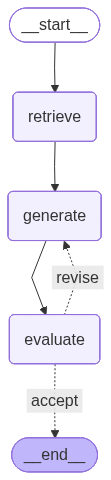

In [14]:
from IPython.display import Image, display

display(Image(self_correcting_rag.get_graph().draw_mermaid_png()))

In [15]:
# Test 1: Question answerable from context — should pass evaluation quickly
print("=" * 60)
print("TEST: What is a StateGraph in LangGraph?")
print("=" * 60)

result = self_correcting_rag.invoke({"question": "What is a StateGraph in LangGraph?"})
print(f"\nFinal answer (revision {result['revision_count']}, faithfulness {result['faithfulness_score']}/5):")
print(result["generation"])

TEST: What is a StateGraph in LangGraph?
Retrieved 3 documents
Generated answer (revision 0): A StateGraph in LangGraph is a structure used to define workflows as directed graphs, where each nod...
Faithfulness: 4/5 — The answer states that a StateGraph is a structure used to define workflows as directed graphs with nodes representing steps and edges defining transitions. The context confirms that LangGraph uses a StateGraph to define workflows as directed graphs with nodes and edges. However, the context does not explicitly mention that nodes represent steps or that edges define possible transitions, nor does it say that it serves as the foundational model for managing execution flow. These are reasonable inferences but not directly supported by the context. Therefore, the answer is mostly faithful but includes some inferred details not explicitly stated in the context.
-> Accepting (score 4/5)

Final answer (revision 1, faithfulness 4/5):
A StateGraph in LangGraph is a structure used

In [16]:
# Test 2: Question where the model might hallucinate — evaluator should catch it
print("=" * 60)
print("TEST: Who created LangGraph and when was it first released?")
print("=" * 60)

result = self_correcting_rag.invoke(
    {"question": "Who created LangGraph and when was it first released?"}
)
print(f"\nFinal answer (revision {result['revision_count']}, faithfulness {result['faithfulness_score']}/5):")
print(result["generation"])

TEST: Who created LangGraph and when was it first released?
Retrieved 3 documents
Generated answer (revision 0): LangGraph was created by LangChain, and it was first released in February 2024....
Faithfulness: 1/5 — The context does not provide any information about who created LangGraph or when it was first released. The answer claims that LangGraph was created by LangChain and first released in February 2024, but these details are not supported by the given context. Therefore, the answer includes information not present in the context, making it unfaithful.
-> Revising (score 1/5, revision 1)
Generated answer (revision 1): The context does not provide information about who created LangGraph or when it was first released....
Faithfulness: 5/5 — The answer correctly states that the context does not provide information about who created LangGraph or when it was first released. It does not make any unsupported claims and accurately reflects the information given in the context.
-> Accept

## 4. Comparing LLM-powered rubric engines against a gold evaluation set

Instead of evaluating one answer at a time, let's build a **gold test set** with expected scores, then ask multiple models the same questions and compare their rubric scores against our expectations. This reveals which models are faithful, which hallucinate, and which are too verbose — systematically.

In [17]:
# --- Gold test set ---
# Each entry has: question, context, and our EXPECTED scores (the "gold label").
# We'll compare actual model outputs against these expectations.

CONTEXT = (
    "LangGraph uses a StateGraph to define workflows as directed graphs with nodes and edges. "
    "Checkpointing in LangGraph allows you to save and resume graph state across invocations. "
    "Conditional edges in LangGraph enable dynamic routing based on state values."
)

GOLD_TEST_SET = [
    {
        "question": "What are the key features of LangGraph?",
        "context": CONTEXT,
        "ai_answer": "Checkpointing, Conditional edges, StateGraphs are some of the key features of LangGraph.",
        # A perfect answer should be grounded, complete, and concise
        "expected": {"faithfulness": 5, "completeness": 5, "conciseness": 5}
    },
    # this is an example of an snwer that's too long and unncessary, so the conciseness score is low
    {
        "question": "What are the key features of LangGraph?",
        "context": CONTEXT,
        "ai_answer": "LangGraph is a Python library for building stateful, multi-actor applications with LLMs. "
        "It provides a StateGraph class for defining workflows as directed graphs." 
        "It also supports checkpointing, conditional edges, and other features for building complex applications."
        "It is a powerful tool for building stateful, multi-actor applications with LLMs.",
        "expected": {"faithfulness": 5, "completeness": 5, "conciseness": 1}
    },
    # this is an example of an answer that's not faithful to the context, so the faithfulness score is low
    {
        "question": "What are the key features of LangGraph?",
        "context": CONTEXT,
        "ai_answer": "LangGraph is a TypeScript library for building stateful, multi-actor applications with LLMs. "
        "It provides a StateGraph class for defining workflows as directed graphs.",
        "expected": {"faithfulness": 2, "completeness": 3, "conciseness": 5}
    },
    # this is an example of a not complete answer, so the completeness score is low
    {
        "question": "What are the key features of LangGraph?",
        "context": CONTEXT,
        "ai_answer": "LangGraph is a Python library",
        "expected": {"faithfulness": 5, "completeness": 1, "conciseness": 5}
    }
]

print(f"Gold test set: {len(GOLD_TEST_SET)} cases")

Gold test set: 4 cases


In [20]:
# --- Models to compare via OpenRouter ---
MODELS_TO_COMPARE = [
    "mistralai/mistral-small-3.2-24b-instruct",
    "anthropic/claude-opus-4.6",
    "openai/gpt-4.1-nano",
    "openai/gpt-4.1-mini",
    "openai/gpt-4.1"
]

print(f"Will compare {len(MODELS_TO_COMPARE)} models × {len(GOLD_TEST_SET)} test cases "
      f"= {len(MODELS_TO_COMPARE) * len(GOLD_TEST_SET)} evaluations")

Will compare 5 models × 4 test cases = 20 evaluations


In [21]:
import time

from tqdm import tqdm
all_results = []

for model_name in tqdm(MODELS_TO_COMPARE):
    print(f"\n{'=' * 60}")
    print(f"MODEL: {model_name}")
    print(f"{'=' * 60}")

    for i, tc in enumerate(GOLD_TEST_SET, 1):

        # 2) Evaluate it with our rubric judge
        before_time = time.time()
        try:
            evaluation = evaluate_response(
                question=tc["question"],
                context=tc["context"],
                answer=tc["ai_answer"],
                model_name=model_name,
            )
        except Exception as e:
            print(f"Error evaluating {model_name}: {e}")
            evaluation = None
        after_time = time.time()
        print(f"Time taken: {after_time - before_time:.2f} seconds")

        # 3) Compute deltas vs. gold expectations
        expected = tc["expected"]
        if evaluation:
            delta_f = evaluation.faithfulness - expected["faithfulness"]
            delta_c = evaluation.completeness - expected["completeness"]
            delta_co = evaluation.conciseness - expected["conciseness"]
        else:
            delta_f = None
            delta_c = None
            delta_co = None

        all_results.append({
            "model": model_name,
            "question": tc["question"][:50] + "...",
            "faithfulness": evaluation.faithfulness,
            "completeness": evaluation.completeness,
            "conciseness": evaluation.conciseness,
            "exp_faith": expected["faithfulness"],
            "exp_comp": expected["completeness"],
            "exp_conc": expected["conciseness"],
            "Δ_faith": delta_f,
            "Δ_comp": delta_c,
            "Δ_conc": delta_co,
            "ai_answer": tc["ai_answer"],
            "time_taken": after_time - before_time,
        })

        print(f"\n  Q{i}: {tc['question'][:55]}...")
        print(f"  Scores   — F:{evaluation.faithfulness}  C:{evaluation.completeness}  Co:{evaluation.conciseness}")
        print(f"  Expected — F:{expected['faithfulness']}  C:{expected['completeness']}  Co:{expected['conciseness']}")
        print(f"  Deltas   — ΔF:{delta_f:+d}  ΔC:{delta_c:+d}  ΔCo:{delta_co:+d}")


  0%|          | 0/5 [00:00<?, ?it/s]


MODEL: mistralai/mistral-small-3.2-24b-instruct
Time taken: 1.50 seconds

  Q1: What are the key features of LangGraph?...
  Scores   — F:5  C:5  Co:5
  Expected — F:5  C:5  Co:5
  Deltas   — ΔF:+0  ΔC:+0  ΔCo:+0
Time taken: 1.49 seconds

  Q2: What are the key features of LangGraph?...
  Scores   — F:3  C:3  Co:3
  Expected — F:5  C:5  Co:1
  Deltas   — ΔF:-2  ΔC:-2  ΔCo:+2
Time taken: 1.41 seconds

  Q3: What are the key features of LangGraph?...
  Scores   — F:4  C:3  Co:5
  Expected — F:2  C:3  Co:5
  Deltas   — ΔF:+2  ΔC:+0  ΔCo:+0


 20%|██        | 1/5 [00:05<00:23,  5.80s/it]

Time taken: 1.40 seconds

  Q4: What are the key features of LangGraph?...
  Scores   — F:2  C:1  Co:5
  Expected — F:5  C:1  Co:5
  Deltas   — ΔF:-3  ΔC:+0  ΔCo:+0

MODEL: anthropic/claude-opus-4.6
Time taken: 4.87 seconds

  Q1: What are the key features of LangGraph?...
  Scores   — F:5  C:5  Co:5
  Expected — F:5  C:5  Co:5
  Deltas   — ΔF:+0  ΔC:+0  ΔCo:+0
Time taken: 6.28 seconds

  Q2: What are the key features of LangGraph?...
  Scores   — F:3  C:3  Co:3
  Expected — F:5  C:5  Co:1
  Deltas   — ΔF:-2  ΔC:-2  ΔCo:+2
Time taken: 5.14 seconds

  Q3: What are the key features of LangGraph?...
  Scores   — F:2  C:2  Co:4
  Expected — F:2  C:3  Co:5
  Deltas   — ΔF:+0  ΔC:-1  ΔCo:-1


 40%|████      | 2/5 [00:26<00:43, 14.63s/it]

Time taken: 4.51 seconds

  Q4: What are the key features of LangGraph?...
  Scores   — F:1  C:1  Co:3
  Expected — F:5  C:1  Co:5
  Deltas   — ΔF:-4  ΔC:+0  ΔCo:-2

MODEL: openai/gpt-4.1-nano
Time taken: 1.28 seconds

  Q1: What are the key features of LangGraph?...
  Scores   — F:5  C:4  Co:5
  Expected — F:5  C:5  Co:5
  Deltas   — ΔF:+0  ΔC:-1  ΔCo:+0
Time taken: 1.98 seconds

  Q2: What are the key features of LangGraph?...
  Scores   — F:5  C:4  Co:3
  Expected — F:5  C:5  Co:1
  Deltas   — ΔF:+0  ΔC:-1  ΔCo:+2
Time taken: 1.08 seconds

  Q3: What are the key features of LangGraph?...
  Scores   — F:3  C:2  Co:4
  Expected — F:2  C:3  Co:5
  Deltas   — ΔF:+1  ΔC:-1  ΔCo:-1


 60%|██████    | 3/5 [00:33<00:22, 11.01s/it]

Time taken: 2.35 seconds

  Q4: What are the key features of LangGraph?...
  Scores   — F:2  C:2  Co:4
  Expected — F:5  C:1  Co:5
  Deltas   — ΔF:-3  ΔC:+1  ΔCo:-1

MODEL: openai/gpt-4.1-mini
Time taken: 2.06 seconds

  Q1: What are the key features of LangGraph?...
  Scores   — F:5  C:3  Co:5
  Expected — F:5  C:5  Co:5
  Deltas   — ΔF:+0  ΔC:-2  ΔCo:+0
Time taken: 2.54 seconds

  Q2: What are the key features of LangGraph?...
  Scores   — F:5  C:5  Co:5
  Expected — F:5  C:5  Co:1
  Deltas   — ΔF:+0  ΔC:+0  ΔCo:+4
Time taken: 3.08 seconds

  Q3: What are the key features of LangGraph?...
  Scores   — F:5  C:3  Co:5
  Expected — F:2  C:3  Co:5
  Deltas   — ΔF:+3  ΔC:+0  ΔCo:+0


 80%|████████  | 4/5 [00:43<00:10, 10.64s/it]

Time taken: 2.39 seconds

  Q4: What are the key features of LangGraph?...
  Scores   — F:4  C:1  Co:5
  Expected — F:5  C:1  Co:5
  Deltas   — ΔF:-1  ΔC:+0  ΔCo:+0

MODEL: openai/gpt-4.1
Time taken: 2.46 seconds

  Q1: What are the key features of LangGraph?...
  Scores   — F:5  C:4  Co:5
  Expected — F:5  C:5  Co:5
  Deltas   — ΔF:+0  ΔC:-1  ΔCo:+0
Time taken: 6.04 seconds

  Q2: What are the key features of LangGraph?...
  Scores   — F:5  C:5  Co:4
  Expected — F:5  C:5  Co:1
  Deltas   — ΔF:+0  ΔC:+0  ΔCo:+3
Time taken: 2.76 seconds

  Q3: What are the key features of LangGraph?...
  Scores   — F:5  C:3  Co:5
  Expected — F:2  C:3  Co:5
  Deltas   — ΔF:+3  ΔC:+0  ΔCo:+0


100%|██████████| 5/5 [00:59<00:00, 11.90s/it]

Time taken: 4.87 seconds

  Q4: What are the key features of LangGraph?...
  Scores   — F:3  C:1  Co:5
  Expected — F:5  C:1  Co:5
  Deltas   — ΔF:-2  ΔC:+0  ΔCo:+0


PER-MODEL SUMMARY
                                          avg_faithfulness  avg_completeness  \
model                                                                          
anthropic/claude-opus-4.6                             2.75              2.75   
openai/gpt-4.1-nano                                   3.75              3.00   
mistralai/mistral-small-3.2-24b-instruct              3.50              3.00   
openai/gpt-4.1                                        4.50              3.25   
openai/gpt-4.1-mini                                   4.75              3.00   

                                          avg_conciseness  avg_Δ_faith  \
model                                                                    
anthropic/claude-opus-4.6                            3.75        -1.50   
openai/gpt-4.1-nano                                  4.00        -0.50   
mistralai/mistral-small-3.2-24b-instruct             4.50        -0.75   
openai/gpt-4.1                                     

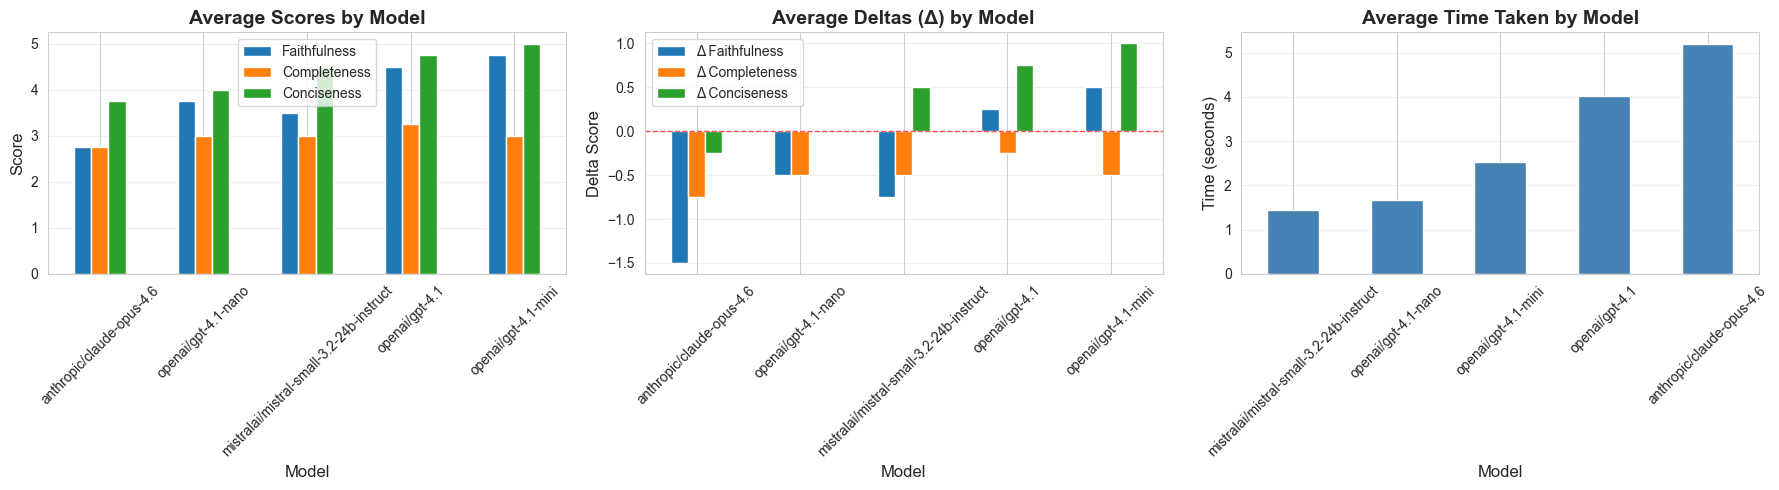

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(all_results)

# --- Per-model summary ---
print("=" * 60)
print("PER-MODEL SUMMARY")
print("=" * 60)

summary = df.groupby("model").agg(
    avg_faithfulness=("faithfulness", "mean"),
    avg_completeness=("completeness", "mean"),
    avg_conciseness=("conciseness", "mean"),
    avg_Δ_faith=("Δ_faith", "mean"),
    avg_Δ_comp=("Δ_comp", "mean"),
    avg_Δ_conc=("Δ_conc", "mean"),
    avg_time=("time_taken", "mean"),
)
# Add overall performance column (0 to 1 scale)
# Normalize each metric to 0-1 scale (assuming scores are 1-5) and average them
summary['overall_performance'] = (
    (summary['avg_faithfulness'] - 1) / 4 * 0.33 +
    (summary['avg_completeness'] - 1) / 4 * 0.33 +
    (summary['avg_conciseness'] - 1) / 4 * 0.33
)
summary = summary.round(2)

print(summary.sort_values(by='overall_performance', ascending=True))
print()

# Set style
sns.set_style("whitegrid")

# 1. Average scores by model (grouped bar chart)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Average Scores by Model
ax1 = axes[0]
summary.sort_values(by='overall_performance', ascending=True)[['avg_faithfulness', 'avg_completeness', 'avg_conciseness']].plot(
    kind='bar', ax=ax1, rot=45
)
ax1.set_title('Average Scores by Model', fontsize=14, fontweight='bold')
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.legend(['Faithfulness', 'Completeness', 'Conciseness'])
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Average Deltas by Model
ax2 = axes[1]
summary.sort_values(by='overall_performance', ascending=True)[['avg_Δ_faith', 'avg_Δ_comp', 'avg_Δ_conc']].plot(
    kind='bar', ax=ax2, rot=45
)
ax2.set_title('Average Deltas (Δ) by Model', fontsize=14, fontweight='bold')
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Delta Score', fontsize=12)
ax2.legend(['Δ Faithfulness', 'Δ Completeness', 'Δ Conciseness'])
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Average Time Taken by Model
ax3 = axes[2]
summary['avg_time'].sort_values(ascending=True).plot(kind='bar', ax=ax3, rot=45, color='steelblue')
ax3.set_title('Average Time Taken by Model', fontsize=14, fontweight='bold')
ax3.set_xlabel('Model', fontsize=12)
ax3.set_ylabel('Time (seconds)', fontsize=12)
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
# Examples where models overscored on conciseness. Do you agree? 
#  If you need to adjust your test set, do it because these statistics made you change your mind, not simply because the AI disagrees with you.
print("=" * 80)
df.groupby(["question", "ai_answer"]).agg({"Δ_conc": "mean", "exp_conc": "mean", "conciseness": "mean"}).sort_values(by="Δ_conc", ascending=False).head(10)

Δ_conc  \
question                                   ai_answer                                                    
What are the key features of LangGraph?... LangGraph is a Python library for building stat...     2.6   
                                           Checkpointing, Conditional edges, StateGraphs a...     0.0   
                                           LangGraph is a TypeScript library for building ...    -0.4   
                                           LangGraph is a Python library                         -0.6   

                                                                                               exp_conc  \
question                                   ai_answer                                                      
What are the key features of LangGraph?... LangGraph is a Python library for building stat...       1.0   
                                           Checkpointing, Conditional edges, StateGraphs a...       5.0   
                                           LangGraph is a TypeScript library for building ...       5.0   
                                           LangGraph is a Python library                            5.0   

                                                                                               conciseness  
question                                   ai_answer                                                        
What are the key features of LangGraph?... LangGraph is a Python library for building stat...          3.6  
                                           Checkpointing, Conditional edges, StateGraphs a...          5.0  
                                           LangGraph is a TypeScript library for building ...          4.6  
                                           LangGraph is a Python library                               4.4